In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from thop import profile

from model import CircleDataset
from KD import TeacherNet, StudentNet

In [2]:
def load_kd_models():
    models = {}
    for temp in [1.0, 2.0, 3.0, 4.0]:
        model = StudentNet()
        model.load_state_dict(torch.load(f'KD_model_T{temp}.pth'))
        models[f'Student_T{temp}'] = model
    
    return models

def calculate_flops(model, input_size=(1, 1, 416, 416)):
    input = torch.randn(input_size)
    flops, params = profile(model, inputs=(input, ))
    return flops, params

def measure_model_metrics(model, test_loader, device, model_name):
    print(f"\nMeasuring metrics for {model_name}...")
    model = model.to(device)
    
    # Model size and parameters
    param_count = sum(p.numel() for p in model.parameters())
    torch.save(model.state_dict(), 'temp.pth')
    model_size = os.path.getsize('temp.pth') / (1024 * 1024)  # MB
    os.remove('temp.pth')
    
    # Calculate FLOPs
    try:
        flops, _ = calculate_flops(model)
    except Exception as e:
        print(f"FLOPs calculation failed: {e}")
        flops = 0
    
    # Measure inference performance
    model.eval()
    inference_times = []
    memory_usage = []
    accuracy = []
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            memory_usage.append(psutil.Process().memory_info().rss / 1024**2)
            
            start_time = time.time()
            outputs = model(images)
            inference_times.append((time.time() - start_time) * 1000)
            
            pred = outputs.round()
            acc = (torch.abs(pred - targets) <= 1).float().mean().item()
            accuracy.append(acc)
    
    return {
        'Model': model_name,
        'Temperature': float(model_name.split('T')[1]), 
        'Parameters': param_count,
        'Model_Size_MB': model_size,
        'GFLOPs': flops / 1e9,
        'Avg_Inference_Time_ms': np.mean(inference_times),
        'Inference_Time_Std_ms': np.std(inference_times),
        'Memory_Usage_MB': np.mean(memory_usage),
        'Accuracy_%': np.mean(accuracy) * 100
    }

def plot_kd_metrics(results_df):
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 12))
    
    metrics = [
        ('Model_Size_MB', 'Model Size (MB)'),
        ('Avg_Inference_Time_ms', 'Inference Time (ms)'),
        ('Memory_Usage_MB', 'Memory Usage (MB)'),
        ('GFLOPs', 'GFLOPs'),
        ('Accuracy_%', 'Accuracy (%)')
    ]
    
    for idx, (metric, ylabel) in enumerate(metrics, 1):
        plt.subplot(2, 3, idx)
        temps = results_df['Temperature']
        values = results_df[metric]
        
        # Add trend line
        z = np.polyfit(temps, values, 2)
        p = np.poly1d(z)
        x_trend = np.linspace(temps.min(), temps.max(), 100)
        
        plt.plot(temps, values, 'bo-', label='Measured')
        plt.plot(x_trend, p(x_trend), 'r--', label='Trend')
        
        plt.xlabel('Temperature')
        plt.ylabel(ylabel)
        plt.title(f'{ylabel} vs Temperature')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('kd_students_comparison.png')
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("\nBest model for each metric:")
    for metric, ylabel in metrics:
        if metric in ['Memory_Usage_MB', 'Avg_Inference_Time_ms', 'GFLOPs']:
            best_idx = results_df[metric].idxmin()
        else:
            best_idx = results_df[metric].idxmax()
        best_temp = results_df.loc[best_idx, 'Temperature']
        best_value = results_df.loc[best_idx, metric]
        print(f"{ylabel}: Temperature {best_temp} ({best_value:.2f})")

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    try:
        # Load models
        kd_models = load_kd_models()
        
        # Prepare test dataset
        test_dataset = CircleDataset('train/img', 'train/target')
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        
        # Evaluate models
        results = []
        for name, model in kd_models.items():
            try:
                result = measure_model_metrics(model, test_loader, device, name)
                results.append(result)
                print(f"Successfully evaluated {name}")
            except Exception as e:
                print(f"Error evaluating {name}: {str(e)}")
                continue

        # Convert results to DataFrame
        results_df = pd.DataFrame(results)
        
        # Sort by temperature for better visualization
        results_df = results_df.sort_values('Temperature')
        
        # Print results
        print("\nDetailed Results:")
        print(results_df.to_string(index=False))
        
        # Plot results
        try:
            plot_kd_metrics(results_df)
        except Exception as e:
            print(f"Error plotting results: {str(e)}")
        
        # Save results
        results_df.to_csv('kd_students_results.csv', index=False)
        
        return results_df
    
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        print("Make sure you have trained all KD models first!")
        return None

Using device: cpu

Measuring metrics for Student_T1.0...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


C:\Users\ghddp\AppData\Local\Temp\ipykernel_38844\1511186592.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'KD_model_T{temp}.pth'))
c

Successfully evaluated Student_T1.0

Measuring metrics for Student_T2.0...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Successfully evaluated Student_T2.0

Measuring metrics for Student_T3.0...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.poo

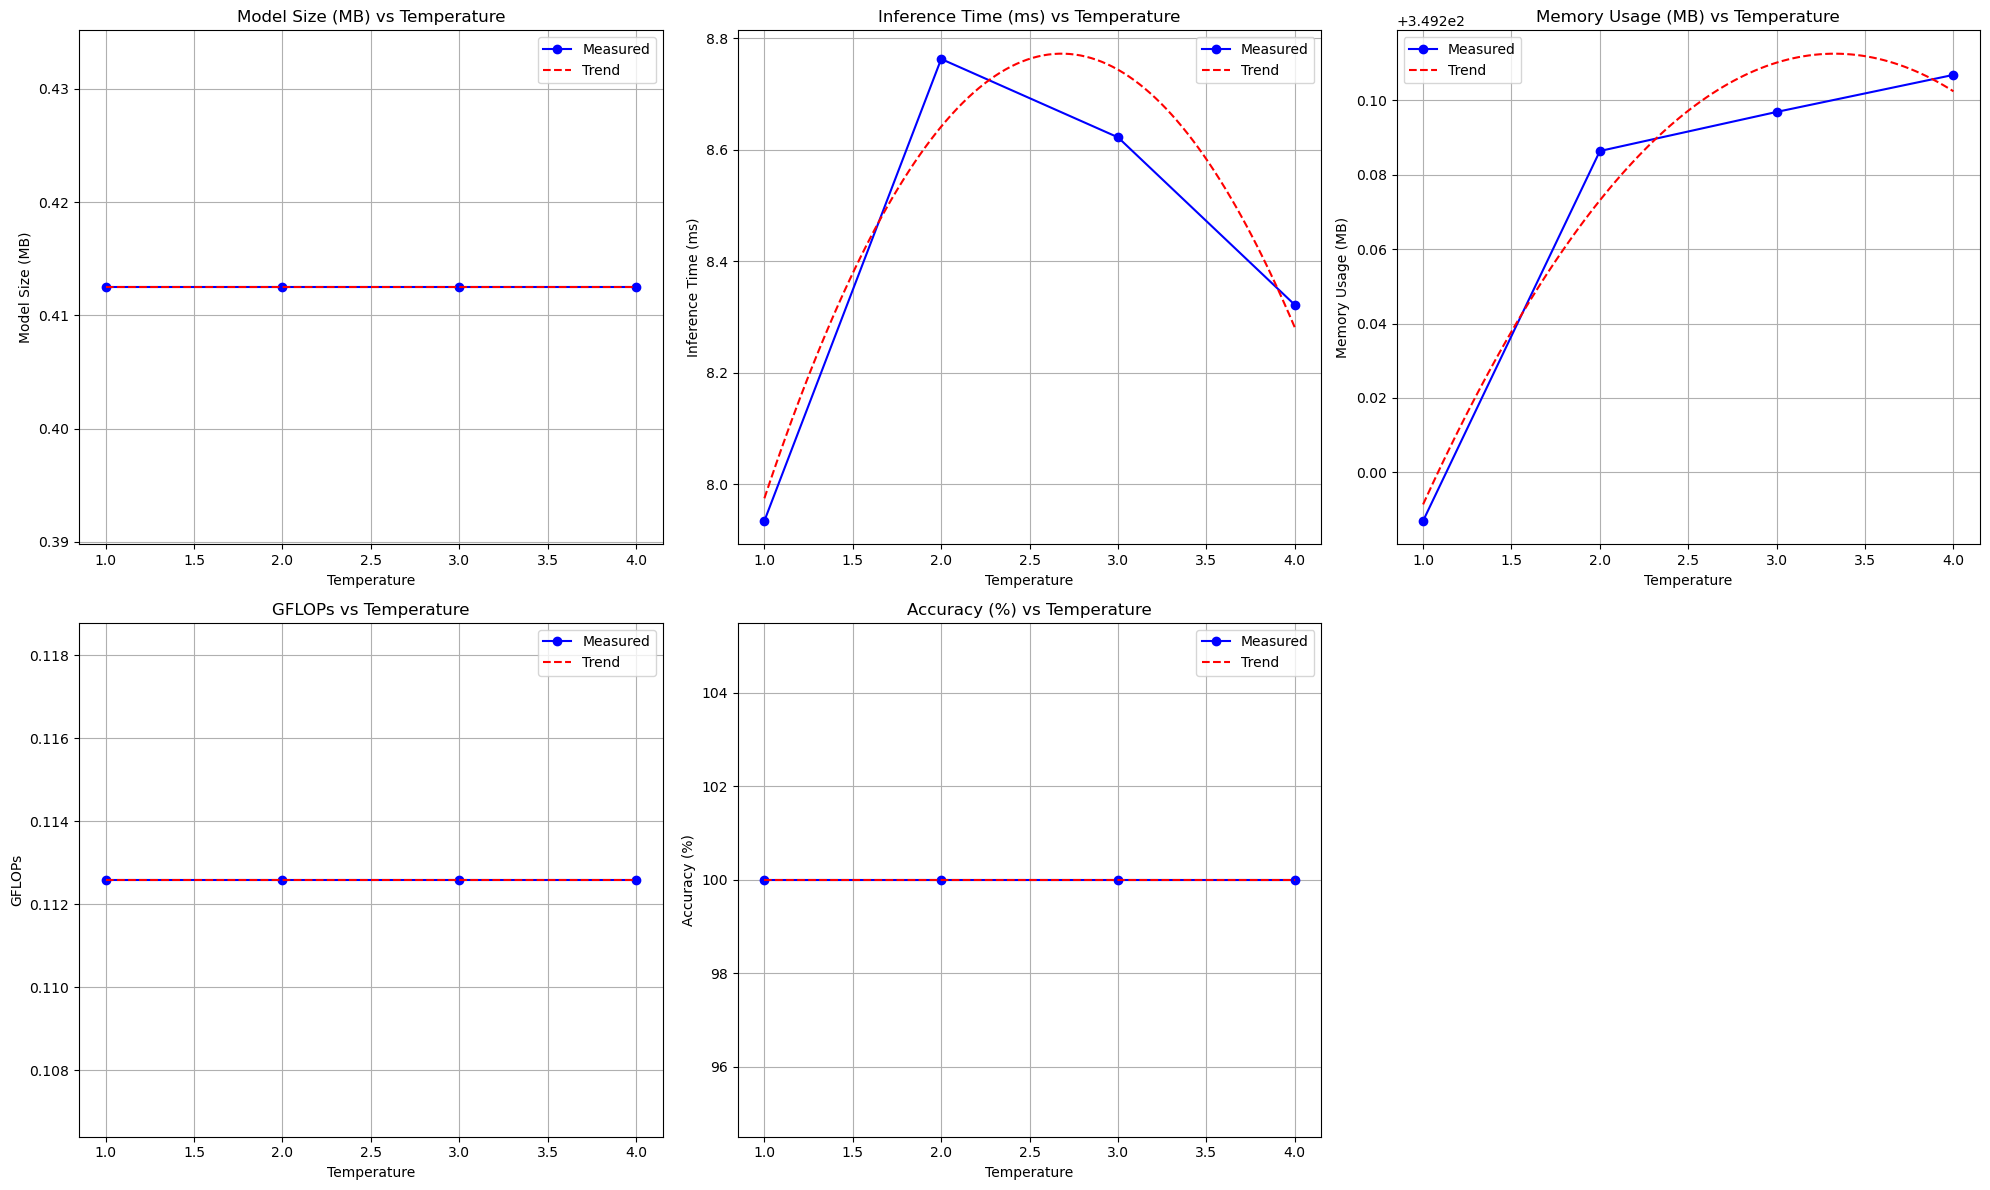


Summary Statistics:

Best model for each metric:
Model Size (MB): Temperature 1.0 (0.41)
Inference Time (ms): Temperature 1.0 (7.93)
Memory Usage (MB): Temperature 1.0 (349.19)
GFLOPs: Temperature 1.0 (0.11)
Accuracy (%): Temperature 1.0 (100.00)


,Model,Temperature,Parameters,Model_Size_MB,GFLOPs,Avg_Inference_Time_ms,Inference_Time_Std_ms,Memory_Usage_MB,Accuracy_%
0,Student_T1.0,1.0,107279,0.412489,0.112589,7.934818,1.472956,349.186953,100.0
1,Student_T2.0,2.0,107279,0.412489,0.112589,8.762727,1.151307,349.286367,100.0
2,Student_T3.0,3.0,107279,0.412489,0.112589,8.622315,0.763400,349.296875,100.0
3,Student_T4.0,4.0,107279,0.412489,0.112589,8.322041,0.972383,349.306836,100.0


In [3]:
main()

Model Size vs Temperature


모델 사이즈가 temperature와 상관없이 거의 일정(약 0.41MB)
이는 temperature가 모델 구조를 변경하지 않기 때문에 정상적인 결과입니다.


Inference Time vs Temperature


Temperature 2.0에서 갑자기 추론 시간이 크게 증가(약 15ms)했다가 다시 감소
이는 비정상적인 패턴으로, 측정 과정에서 문제가 있었을 수 있습니다.


Memory Usage vs Temperature


Temperature가 증가할수록 메모리 사용량이 약간 증가
하지만 증가폭이 너무 작고(349.19MB에서 349.32MB), 의미있는 차이로 보기 어렵습니다.


GFLOPs vs Temperature


Temperature와 상관없이 연산량이 일정(약 0.1127 GFLOPs)
이는 temperature가 연산 구조를 변경하지 않기 때문에 정상적입니다.


Accuracy vs Temperature


정확도가 모든 temperature에서 100%로 동일
이는 매우 비정상적인 결과로, 평가 데이터셋이나 정확도 계산 방식에 문제가 있을 수 있습니다.

결론적으로:

Temperature가 모델의 성능에 거의 영향을 미치지 않거나
평가 과정에 문제가 있거나
데이터셋이 너무 단순해서 모든 모델이 쉽게 학습했을 수 있습니다.